# Analysis of models that predict ENSO well
- takes the 12 models that show an El Nino in DJF 1884 or 1885 AND a La Nina in DJF 1886
- performs SEA and plots results for all 5 volcanoes (both plots and tables of anomalies at 6, 12, 24 months)
- plots a timeseries around Krakatoa eruption
- both temperature and precipitation are analysed

In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [4]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [5]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [6]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [7]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [14]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [15]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [16]:
# select the models which do ENSO well
models = models.sel(model = ['BCC-CSM2-MR', 'BCC-ESM1', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM-FV2', 'CMCC-CM2-HR4', 
                    'CMCC-CM2-SR5', 'EC-Earth3', 'GISS-E2-1-H', 'IITM-ESM', 'NorESM2-LM', 'TaiESM1'])

In [17]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 12 models will be used in all subsequent calculations: 

['BCC-CSM2-MR' 'BCC-ESM1' 'CAS-ESM2-0' 'CESM2' 'CESM2-WACCM-FV2'
 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'EC-Earth3' 'GISS-E2-1-H' 'IITM-ESM'
 'NorESM2-LM' 'TaiESM1']


Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  
## Select out regions and eruption dates

In [18]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

In [19]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
# e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
# e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']

In [20]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [21]:
print(e_pre5yrs[1], e_pre3mon[0], e_post5yrs)

1897-10-01 00:00:00 1883-05-01 00:00:00 DatetimeIndex(['1888-09-01', '1907-11-01', '1968-04-01', '1987-05-01',
               '1996-07-01'],
              dtype='datetime64[ns]', freq=None)


In [22]:
# eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [23]:
# select out hte 10 year time frame around each eruption (5yrs before and after)
# tas
Krakatau = models_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = models_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = models_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = models_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = models_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

## Anomalies 

In [24]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

In [25]:
# store all eruptions in one array
composite_mon_Glob = func.reset_time(K_mon_anom_Glob, S_mon_anom_Glob, A_mon_anom_Glob, E_mon_anom_Glob, P_mon_anom_Glob, volcanoes)

In [26]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [27]:
# select out each region
composite_mon_SH = composite_mon_Glob.sel(lat=slice(-90,0))
composite_mon_Aus = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
composite_mon_EA = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Multi-model mean and percentiles

In [28]:
# calculate the monthly model mean for monthly anomalies
composite_mmm_Glob = composite_mon_Glob.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_SH = composite_mon_SH.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_Aus = composite_mon_Aus.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_EA = composite_mon_EA.mean(dim='model').mean(dim=('lat','lon'))

In [29]:
# calcuate the lat lon mean (llm)
composite_llm_Glob = composite_mon_Glob.mean(dim=('lat','lon'))
composite_llm_SH = composite_mon_SH.mean(dim=('lat','lon'))
composite_llm_Aus = composite_mon_Aus.mean(dim=('lat','lon'))
composite_llm_EA = composite_mon_EA.mean(dim=('lat','lon'))

In [30]:
# calculate percentile
# 10th percentile
p10_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])

# 90th percentile
p90_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])

In [31]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_SH = composite_mmm_SH.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')
V_composite_mmm_EA = composite_mmm_EA.mean(dim='volcano')

In [32]:
# calculate standard deviation
std_Glob = func.std_bounds_MV(composite_llm_Glob, V_composite_mmm_Glob)
std_SH = func.std_bounds_MV(composite_llm_SH, V_composite_mmm_SH)
std_Aus = func.std_bounds_MV(composite_llm_Aus, V_composite_mmm_Aus)
std_EA = func.std_bounds_MV(composite_llm_EA, V_composite_mmm_EA)

## Figures

In [33]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")

In [36]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

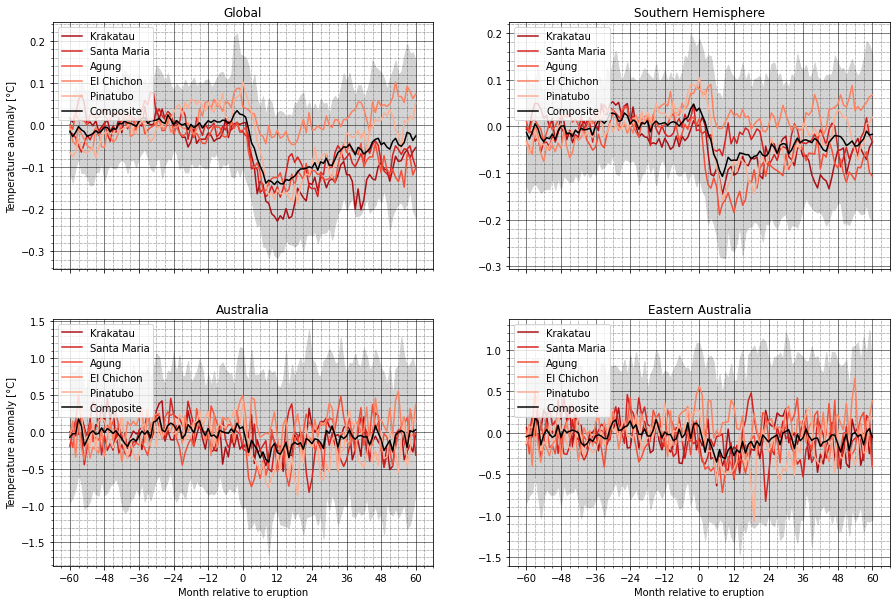

In [86]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.tas, V_composite_mmm_Glob.tas, p10_Glob.tas, p90_Glob.tas, reds, ax = axes[0,0])
func2.SEA_plots(composite_mmm_SH.tas, V_composite_mmm_SH.tas, p10_SH.tas, p90_SH.tas, reds, ax = axes[0,1])
func2.SEA_plots(composite_mmm_Aus.tas, V_composite_mmm_Aus.tas, p10_Aus.tas, p90_Aus.tas, reds, ax = axes[1,0])
func2.SEA_plots(composite_mmm_EA.tas, V_composite_mmm_EA.tas, p10_EA.tas, p90_EA.tas, reds, ax = axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('ENSO_selected_SEA_tas.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

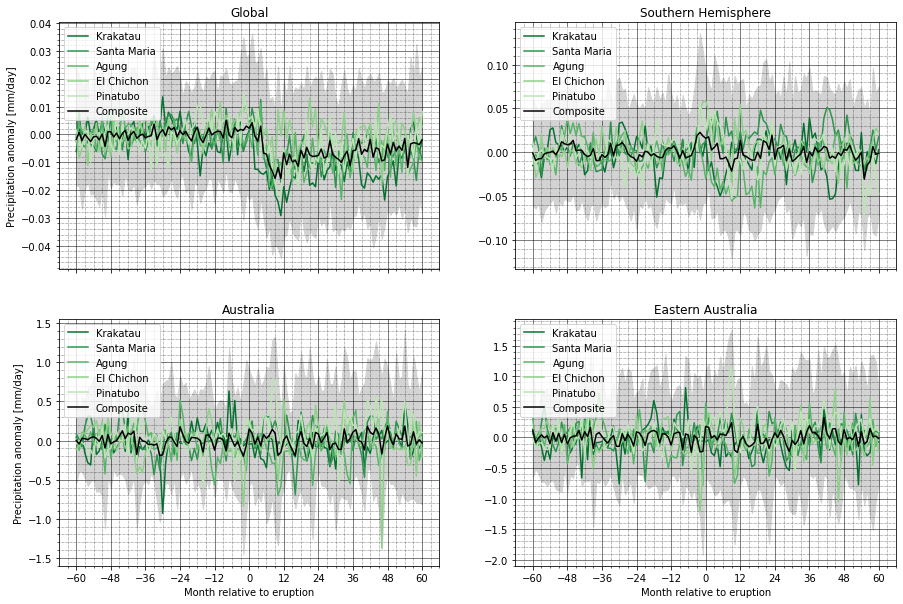

In [87]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[0,0])
func2.SEA_plots(composite_mmm_SH.pr, V_composite_mmm_SH.pr, p10_SH.pr, p90_SH.pr, greens, ax = axes[0,1])
func2.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1,0])
func2.SEA_plots(composite_mmm_EA.pr, V_composite_mmm_EA.pr, p10_EA.pr, p90_EA.pr, greens, ax = axes[1,1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0,0].set(ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel = 'Precipitation anomaly [mm/day]', xlabel = 'Month relative to eruption', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.suptitle('Superposed epoch analysis of precipitation anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('ENSO_selected_SEA_pr.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

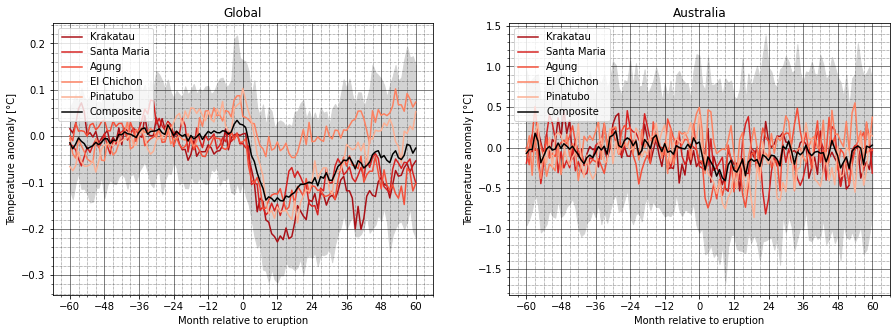

In [88]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.tas, V_composite_mmm_Glob.tas, p10_Glob.tas, p90_Glob.tas, reds, ax = axes[0])
func2.SEA_plots(composite_mmm_Aus.tas, V_composite_mmm_Aus.tas, p10_Aus.tas, p90_Aus.tas, reds, ax = axes[1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')

#fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('ENSO_selected_SEA_Glob&Aus_tas.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

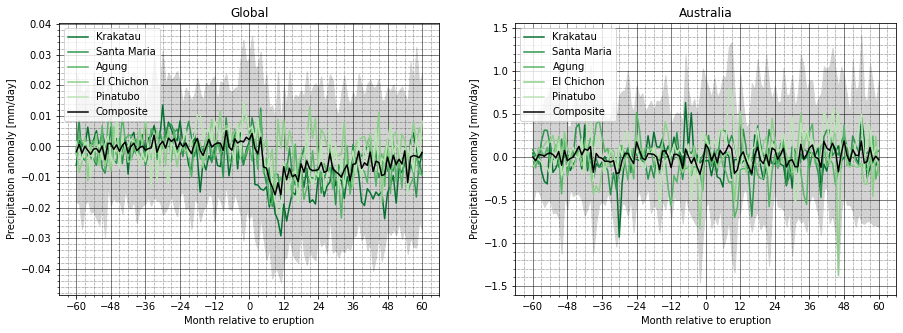

In [89]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[0])
func2.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0].set(xlabel = 'Month relative to eruption', ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = 'Precipitation anomaly [mm/day]', title = 'Australia')

#fig.suptitle('Superposed epoch analysis of precipitation anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('ENSO_selected_SEA_Glob&Aus_pr.png', dpi=300, bbox_inches='tight')

# stat sig tables

In [42]:
# check average anomalies for 3 time periods, 6, 12, 24 months post eruption
model_check_6mon_Aus = func.anomaly_check(composite_llm_Aus, 0, 6)
model_check_12mon_Aus = func.anomaly_check(composite_llm_Aus, 0, 12)
model_check_24mon_Aus = func.anomaly_check(composite_llm_Aus, 0, 24)

In [43]:
# set the colour scale for tables 
colours_tas = np.array(['royalblue', 'lightblue', 'lightcoral', 'crimson'])
colours_pr = np.array(['chocolate', 'goldenrod', 'mediumaquamarine', 'darkcyan'])

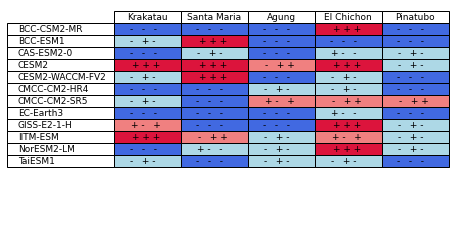

In [44]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for Aus
fig, axes = plt.subplots(1)

func2.mod_check_plot2(model_check_6mon_Aus.tas, model_check_12mon_Aus.tas, model_check_24mon_Aus.tas, colours_tas, ax=axes)

plt.savefig('ENSO_selected_model_table_tas_Aus.pdf', dpi=300, bbox_inches='tight')

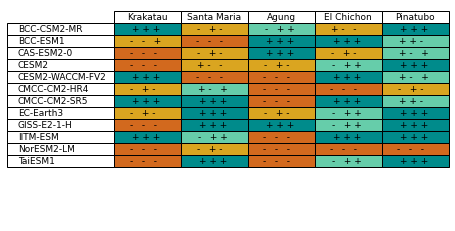

In [45]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for Aus
fig, axes = plt.subplots(1)

func2.mod_check_plot2(model_check_6mon_Aus.pr, model_check_12mon_Aus.pr, model_check_24mon_Aus.pr, colours_pr, ax=axes)

plt.savefig('ENSO_selected_model_table_pr_Aus.pdf', dpi=300, bbox_inches='tight')

# Time series

In [60]:
# use functions to calculate the monthly anomalies for the globe
monthly_anom_glob = func.monthly_anomaly(models_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0])), '1850-01', '1881-01')

In [61]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(-90,0)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90))

In [62]:
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [63]:
# Take the multimodel mean for each region
mmm_mon_Glob = monthly_anom_glob.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_SH = monthly_anom_SH.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_NH = monthly_anom_NH.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_Aus = monthly_anom_Aus.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_EA = monthly_anom_EA.mean(dim='model').mean(dim=['lat','lon'])

In [66]:
# take lat lon mean
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [67]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_SH = llm_SH.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_NH = llm_NH.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_Aus = llm_Aus.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_EA = llm_EA.chunk({'model': -1}).quantile(0.1, dim=['model'])

In [68]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_SH = llm_SH.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_NH = llm_NH.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_Aus = llm_Aus.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_EA = llm_EA.chunk({'model': -1}).quantile(0.9, dim=['model'])

In [69]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [70]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

In [90]:
func2=reload(func2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


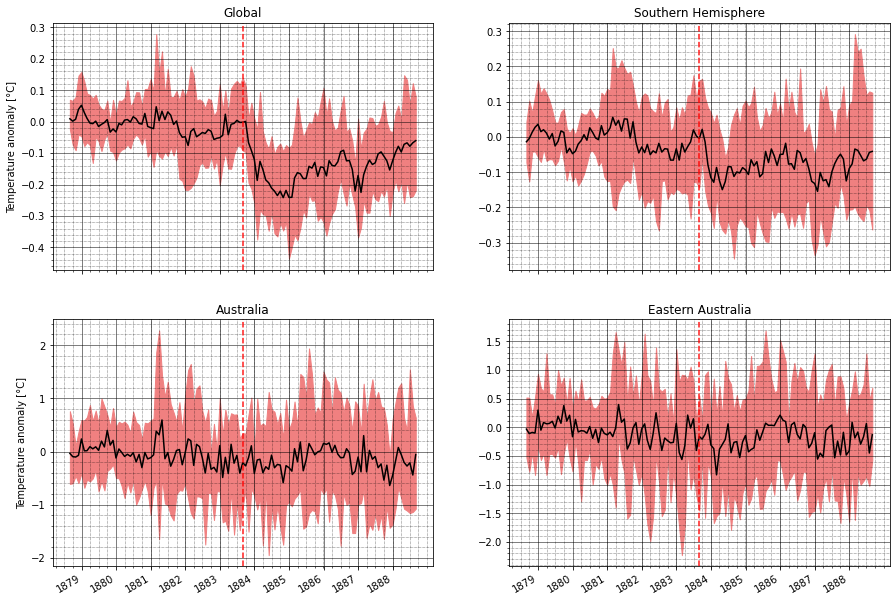

In [91]:
# Monthly temperature anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
func2.timeseries_graph(mmm_mon_Glob.tas, p10_mon_Glob.tas, p90_mon_Glob.tas, ax = axes[0,0], color='lightcoral')
func2.timeseries_graph(mmm_mon_SH.tas, p10_mon_SH.tas, p90_mon_SH.tas, ax = axes[0,1], color='lightcoral')
func2.timeseries_graph(mmm_mon_Aus.tas, p10_mon_Aus.tas, p90_mon_Aus.tas, ax = axes[1,0], color='lightcoral')
func2.timeseries_graph(mmm_mon_EA.tas, p10_mon_EA.tas, p90_mon_EA.tas, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('ENSO_selected_timeseries_tas.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


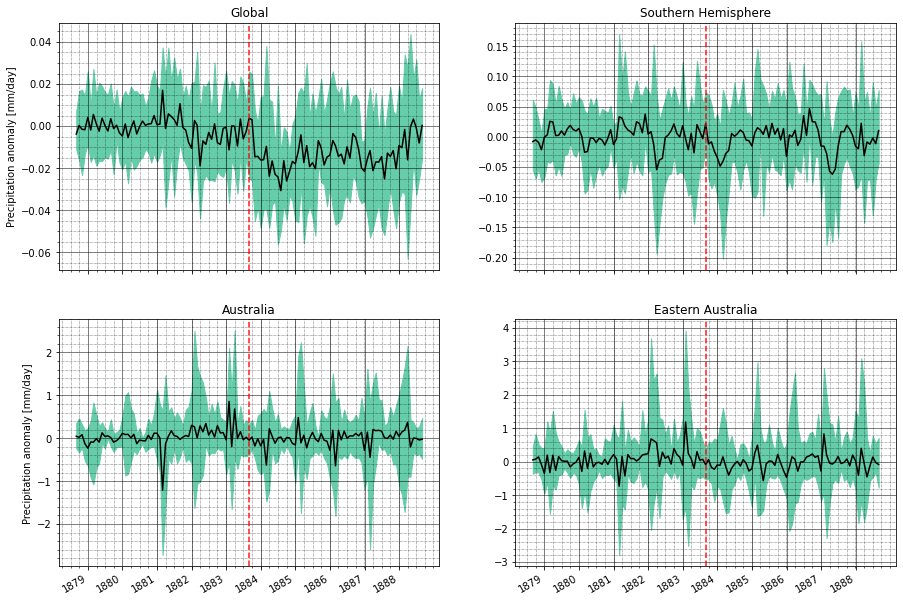

In [94]:
# Monthly temperature anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
func2.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0,0], color='mediumaquamarine')
func2.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[0,1], color='mediumaquamarine')
func2.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
func2.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Precipitation anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years) # sets the frequency to be yearly 
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('ENSO_selected_timeseries_pr.png', dpi=300, bbox_inches='tight')

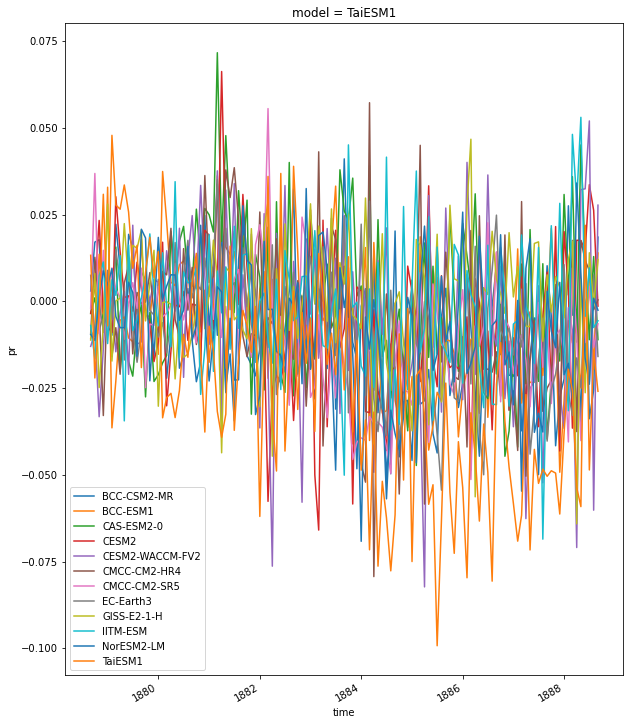

In [65]:
fig, axes = plt.subplots(1, 1, figsize=(10,12)) # make a figure
for m, models in enumerate(monthly_anom_glob.pr.model):
    monthly_anom_glob.pr.sel(model=models).mean(dim=['lat','lon']).plot(label=models.data, ax =axes)
    
plt.legend()